<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Soft_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')

In [4]:
class ReplayBuffer:
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.buffer = []
    self.position = 0

  def add(self, state, action, reward, next_state, done):
    if len(self.buffer) < self.buffer_size :
      self.buffer.append(None)
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.buffer_size

  def sample(self, batch_size):
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = map(np.stack, zip(*batch))
    return state, action, reward, next_state, done

  def __len__(self):
    return len(self.buffer)

In [5]:
class NormalizedActions(gym.ActionWrapper):
  def action(self, action):
    low = self.action_space.low
    high = self.action_space.high

    action = low + (action + 1.0) * 0.5 * (high-low)
    action = np.clip(action, low, high)
    
    return action
  
  def reverse_action(self, action):
    low = self.action_space.low
    high = self.action.space.high

    action = 2 * (action - low) / (high - low) -1
    action = np.clip(action, low, high)

    return action

In [6]:
def plot(frame_idx, rewards):
  clear_output(True)
  plt.figure(figsize=(20,5))
  plt.subplot(131)
  plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
  plt.plot(rewards)
  plt.show()

In [7]:
class ValueNetwork(nn.Module):
  def __init__(self, state_dim, l1_dim = 128, l2_dim = 256, init_w=3e-3):
    super(ValueNetwork, self).__init__()
        
    self.fc1 = nn.Linear(state_dim, l1_dim)
    self.fc2 = nn.Linear(l1_dim, l2_dim)
    self.fc3 = nn.Linear(l2_dim, 1)
        
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)
        
  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [8]:
class SoftQNetwork(nn.Module):
  def __init__(self, num_inputs, num_actions, l1_dim = 128, l2_dim = 256, init_w=3e-3):
    super(SoftQNetwork, self).__init__()
        
    self.fc1 = nn.Linear(num_inputs + num_actions, l1_dim)
    self.fc2 = nn.Linear(l1_dim, l2_dim)
    self.fc3 = nn.Linear(l2_dim, 1)
        
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)
        
  def forward(self, state, action):
    x = torch.cat([state, action], 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x

In [9]:
class PolicyNetwork(nn.Module):
  def __init__(self, num_inputs, num_actions, l1_dim = 128, l2_dim = 256, init_w=3e-3, log_std_min=-20, log_std_max=2):
    super(PolicyNetwork, self).__init__()
        
    self.log_std_min = log_std_min
    self.log_std_max = log_std_max
        
    self.fc1 = nn.Linear(num_inputs, l1_dim)
    self.fc2 = nn.Linear(l1_dim, l2_dim)
        
    self.meanfc = nn.Linear(l2_dim, num_actions)
    self.meanfc.weight.data.uniform_(-init_w, init_w)
    self.meanfc.bias.data.uniform_(-init_w, init_w)
        
    self.log_stdfc = nn.Linear(l2_dim, num_actions)
    self.log_stdfc.weight.data.uniform_(-init_w, init_w)
    self.log_stdfc.bias.data.uniform_(-init_w, init_w)
        
  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
        
    mean = self.meanfc(x)
    log_std = self.log_stdfc(x)
    log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
    return mean, log_std
    
  def evaluate(self, state, epsilon=1e-6):
    mean, log_std = self.forward(state)
    std = log_std.exp()
        
    normal = Normal(mean, std)
    z = normal.sample()
    action = torch.tanh(z)
        
    log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
    log_prob = log_prob.sum(-1, keepdim=True)
        
    return action, log_prob, z, mean, log_std
        
    
  def get_action(self, state):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    mean, log_std = self.forward(state)
    std = log_std.exp()
        
    normal = Normal(mean, std)
    z = normal.sample()
    action = torch.tanh(z)
    action  = action.detach().cpu().numpy()
    
    return action[0]

In [10]:
def soft_q_update(batch_size, gamma=0.99, mean_lambda=1e-3, std_lambda=1e-3, z_lambda=0.0, soft_tau=1e-2,):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state = torch.FloatTensor(state).to(device)
  next_state = torch.FloatTensor(next_state).to(device)
  action = torch.FloatTensor(action).to(device)
  reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
  done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

  expected_q_value = soft_q_net(state, action)
  expected_value   = value_net(state)
  new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)

  target_value = target_value_net(next_state)
  next_q_value = reward + (1 - done) * gamma * target_value
  q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

  expected_new_q_value = soft_q_net(state, new_action)
  next_value = expected_new_q_value - log_prob
  value_loss = value_criterion(expected_value, next_value.detach())

  log_prob_target = expected_new_q_value - expected_value
  policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
    

  mean_loss = mean_lambda * mean.pow(2).mean()
  std_loss = std_lambda * log_std.pow(2).mean()
  z_loss = z_lambda * z.pow(2).sum(1).mean()

  policy_loss += mean_loss + std_loss + z_loss

  soft_q_optimizer.zero_grad()
  q_value_loss.backward()
  soft_q_optimizer.step()

  value_optimizer.zero_grad()
  value_loss.backward()
  value_optimizer.step()

  policy_optimizer.zero_grad()
  policy_loss.backward()
  policy_optimizer.step()

  for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

In [11]:
env = NormalizedActions(gym.make("Pendulum-v0"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
l1_dim = 512
l2_dim = 512

value_net = ValueNetwork(state_dim, l1_dim = l1_dim, l2_dim = l2_dim).to(device)
target_value_net = ValueNetwork(state_dim, l1_dim = l1_dim, l2_dim = l2_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, l1_dim = l1_dim, l2_dim = l2_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, l1_dim = l1_dim, l2_dim = l2_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [12]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

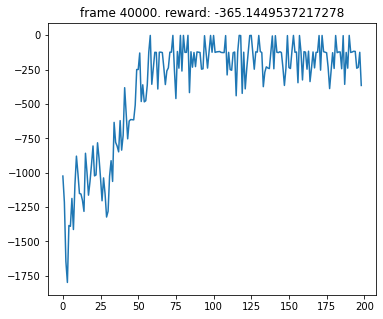

In [13]:
while frame_idx < max_frames:
  state = env.reset()
  episode_reward = 0
    
  for step in range(max_steps):
    action = policy_net.get_action(state)
    next_state, reward, done, _ = env.step(action)
        
    replay_buffer.add(state, action, reward, next_state, done)
    if len(replay_buffer) > batch_size:
      soft_q_update(batch_size)
        
    state = next_state
    episode_reward += reward
    frame_idx += 1
        
    if frame_idx % 1000 == 0:
      plot(frame_idx, rewards)
        
    if done:
      break
        
  rewards.append(episode_reward)